In [1]:
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import re
#!pip install scikit-learn==1.4.0
import sklearn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools

## Data Munging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

## Measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

1.3.0


In [2]:
#General data with all stats: players appear multiple times if they have switched teams during the season
data = pd.read_csv("2023-2034 NBA Season Advanced Player Stats - Sheet1.csv")
#print(data.head())
#print(data.shape)

#half bios + half nba data for 2023-2024 season -- has critical information on player position
data2 = pd.read_csv("2023-2024-Players-NBA-single - Sheet1.csv")
data2['PLAYER'] = data2['PLAYER'].str.replace('\n', ' ') #strip \n in string for PLAYER names
#print(data2.head())
#print(data2.shape)

#bios data for 2023-2024 season: player age, height, and weight, along with some other stats
bios_data = pd.read_csv("2023-2024 NBA Player Bios - Sheet1.csv")
#print(bios_data.head())
#print(bios_data.shape)

speed_data = pd.read_csv("2023-2024 - current NBA player physical stats -- extra dataset - Sheet1.csv")
speed_data = speed_data.filter(['PLAYER', 'AVG SPEED OFF', 'AVG SPEED DEF'])
print(speed_data.head())
print(speed_data.shape)


          PLAYER  AVG SPEED OFF  AVG SPEED DEF
0    A.J. Lawson           4.77           4.44
1       AJ Green           4.72           3.99
2     AJ Griffin           4.77           4.47
3   Aaron Gordon           4.15           3.82
4  Aaron Holiday           4.50           3.97
(572, 3)


In [3]:
#dat3 = merged of data2 and bios data
data3 = pd.merge(data2, bios_data[['PLAYER','AGE']], how = 'left')


def change_feet_inches_to_feet(height):
    element = height.split("-")
    feet = float(element[0])
    inches_feet = float(element[1])/12
    return feet + inches_feet

data3['Height_in_feet'] = data3['HEIGHT'].apply(change_feet_inches_to_feet) #convert height from feet/inches to feet

def change_weight(weight):
    element = weight.split(" ")
    actual_weight = float(element[0])
    return actual_weight
data3['Weight_actual'] = data3['WEIGHT'].apply(change_weight)
    
print(data3.head())
print(data3.shape)

             PLAYER TEAM  NUMBER POSITION HEIGHT   WEIGHT    LAST ATTENDED  \
0  Precious Achiuwa  NYK     5.0        F    6-8  243 lbs          Memphis   
1      Steven Adams  HOU    12.0        C   6-11  265 lbs       Pittsburgh   
2       Bam Adebayo  MIA    13.0      C-F    6-9  255 lbs         Kentucky   
3      Ochai Agbaji  TOR    30.0        G    6-5  215 lbs           Kansas   
4      Santi Aldama  MEM     7.0      F-C    7-0  215 lbs  Loyola-Maryland   

       COUNTRY   AGE  Height_in_feet  Weight_actual  
0      Nigeria  24.0        6.666667          243.0  
1  New Zealand   NaN        6.916667          265.0  
2          USA  26.0        6.750000          255.0  
3          USA  23.0        6.416667          215.0  
4        Spain  23.0        7.000000          215.0  
(582, 11)


In [4]:
#Exploratory data analysis for 2023-2024 season:

#calculate per player:

mp_per_player = data.groupby('Player')['MP'].mean() #Minutes played -- use to filter against people
#who did not play enough, aka our sample size is too small

PER_per_player = data.groupby('Player')['PER'].mean() #PER -- this is our y-variable that we are trying to predict.


BPM_per_player = data.groupby('Player')['BPM'].mean() #Box plus minus
TS_per_player = data.groupby('Player')['TS%'].mean() #True shooting percentage
VORP_per_player = data.groupby('Player')['VORP'].mean() #value over replacement
three_attempt_rate_per_player = data.groupby('Player')['3PAr'].mean() #3-point attempts/total FG attempts
FT_attempt_rate_per_player = data.groupby('Player')['FTr'].mean() #Free-throw attempts/ totalFG attempts

#everything concated together:
EDA_data = pd.concat([PER_per_player, BPM_per_player, TS_per_player,
                     VORP_per_player, three_attempt_rate_per_player,
                     FT_attempt_rate_per_player, mp_per_player], axis=1)

minutes_mask = EDA_data['MP'] > 600 #with 20 minutes per game average, this means ~30 games played on the season

EDA_data_filtered_minutes = EDA_data[minutes_mask] #final dataset

print(EDA_data_filtered_minutes.head())
print(EDA_data_filtered_minutes.shape)



                PER  BPM    TS%  VORP   3PAr    FTr      MP
Player                                                     
Aaron Gordon   16.5  0.9  0.601   1.5  0.184  0.358  2086.0
Aaron Holiday  11.6 -1.1  0.579   0.2  0.520  0.154  1135.0
Aaron Nesmith  12.9 -0.4  0.629   0.7  0.533  0.215  1758.0
Aaron Wiggins  14.9  0.5  0.681   0.6  0.361  0.193   997.0
Al Horford     14.7  3.6  0.647   2.3  0.621  0.075  1604.0
(305, 7)


In [5]:
#playing around with graphs
#sns.relplot(x = 'TS%', y = 'PER', data = EDA_data_filtered_minutes, kind = 'scatter')

#Calculating correlation coefficient for each var with respect to PER
r = np.corrcoef(EDA_data_filtered_minutes['BPM'], EDA_data_filtered_minutes['PER'])
print(r[0,1])

ret = []
for column_name in EDA_data_filtered_minutes.columns:
    if column_name == 'PER':
        continue
    r = np.corrcoef(EDA_data_filtered_minutes[column_name], EDA_data_filtered_minutes['PER'])
    ret.append([column_name, abs(r[0,1])])
    
print(ret)
    


0.8774042525780714
[['BPM', 0.8774042525780714], ['TS%', 0.5272488113850246], ['VORP', 0.8271362175183808], ['3PAr', 0.5313143612755191], ['FTr', 0.5583902109812656], ['MP', 0.43887031121265146]]


In [6]:
#^^remember, data3 is merge of data2 + bios_data

data_final_merged = pd.merge(EDA_data_filtered_minutes, data3, 
                                     left_on = 'Player', right_on = 'PLAYER', how = 'left')
#^^data_final having data3 (all the physical stats) + EDA_filtered data with PER and basketball-related stats
# nicely formated from the original, overall data

data_final_merged = pd.merge(data_final_merged, speed_data, how = 'left')

data_final_merged = data_final_merged.drop(columns=['WEIGHT', 'HEIGHT', 
'NUMBER', 'COUNTRY', 'TEAM', 'LAST ATTENDED'])
#data_final has all the relevant varialbes we want: PER, BPM, TS%, VORP, 3PAr, etc from all four datasets. 

print(data_final_merged.head())


    PER  BPM    TS%  VORP   3PAr    FTr      MP         PLAYER POSITION   AGE  \
0  16.5  0.9  0.601   1.5  0.184  0.358  2086.0   Aaron Gordon        F  28.0   
1  11.6 -1.1  0.579   0.2  0.520  0.154  1135.0  Aaron Holiday        G  27.0   
2  12.9 -0.4  0.629   0.7  0.533  0.215  1758.0  Aaron Nesmith      G-F  24.0   
3  14.9  0.5  0.681   0.6  0.361  0.193   997.0  Aaron Wiggins        G  25.0   
4  14.7  3.6  0.647   2.3  0.621  0.075  1604.0     Al Horford      C-F  37.0   

   Height_in_feet  Weight_actual  AVG SPEED OFF  AVG SPEED DEF  
0        6.666667          235.0           4.15           3.82  
1        6.000000          185.0           4.50           3.97  
2        6.500000          215.0           4.76           4.11  
3        6.416667          190.0           5.07           4.20  
4        6.750000          240.0           4.20           3.80  


0.8701791045543472
['BPM', '3PAr']


<Axes: xlabel='3PAr', ylabel='PER'>

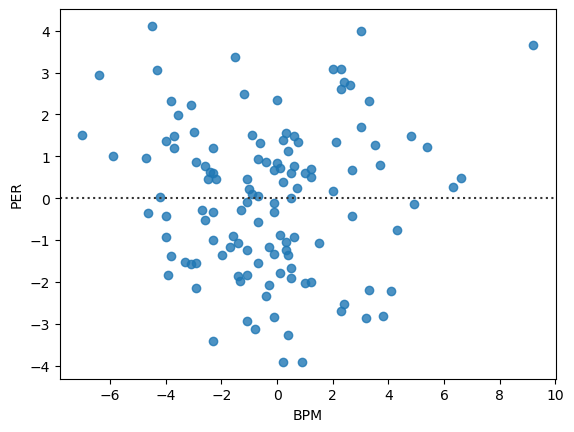

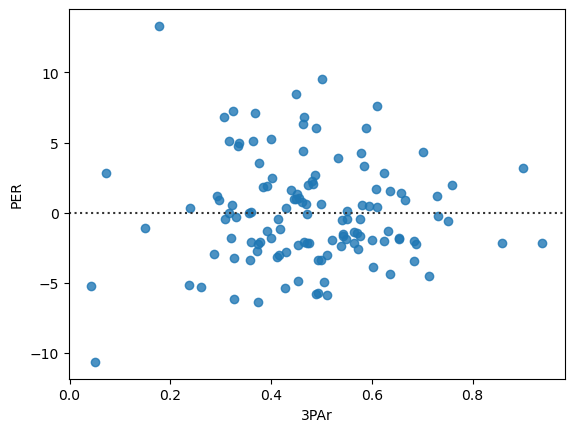

In [7]:
#For point guards or shooting guards:

guards_data_final = data_final_merged[data_final_merged['POSITION'] == 'G']
#print(guards_data_final.head())
#print(guards_data_final.shape)

guards_data_final.dropna(axis = 0, how = 'any')
guard_var_columns = guards_data_final[['BPM', 'VORP', 'TS%', 'AVG SPEED OFF',
                                   'AVG SPEED DEF', 'FTr', '3PAr', 'AGE',
                                   'Height_in_feet', 'Weight_actual']]

#standard scaler as our vars are on different scales.
guard_standardized = pd.DataFrame(StandardScaler().fit_transform(guard_var_columns), columns = guard_var_columns.columns)

selector = SelectKBest(score_func=f_regression, k = 6)
selector.fit(X = guard_standardized, y = guards_data_final['PER'])
x = list(selector.get_feature_names_out())
#this calculates top 6 relevant features/variables from a larger set of features/variables. 


#train test split
q_data = guard_standardized
q_target = guards_data_final['PER']
q_train_data, q_test_data, q_train_target, q_test_target = train_test_split(
    q_data, q_target, test_size=0.20, random_state=100)

#combinations to determine best adj r^2 combination
test_col_list = x
combinations = []
for i in range(1, len(test_col_list)+1):
    combinatorics = [list(x) for x in itertools.combinations(test_col_list, i)]
    combinations.extend(combinatorics)
    
adj_r2_list = [] 
train_target_data = q_train_target.values
for column_combo in combinations:
    linear_model = LinearRegression()
    train_input_data = q_train_data[column_combo].values
    linear_model.fit(X = train_input_data, y = train_target_data)
    predicted_test = linear_model.predict(q_test_data[column_combo].values)
    r2 = r2_score(q_test_target.values, predicted_test)
    adj_r2 = 1 - (1 - r2)*((len(train_input_data)-1)/(len(train_input_data) - train_input_data.shape[1]  - 1))
    adj_r2_list.append(adj_r2)

    
print(max(adj_r2_list))
max_index = adj_r2_list.index(max(adj_r2_list))
print(combinations[max_index])
                    
                  
plt.figure()     
sns.residplot(x = "BPM", 
              y = "PER", 
              data = guards_data_final) 
plt.figure()
sns.residplot(x = "3PAr", 
              y = "PER", 
              data = guards_data_final) 

#add residual plots for the other ones to show linear regression is appropriate
#caveat is that some of our variables are not independent from each other: technically more accurate way would be
#to consider additive and multipicative effects


0.8671259394743109
['BPM', 'FTr']


<Axes: xlabel='FTr', ylabel='PER'>

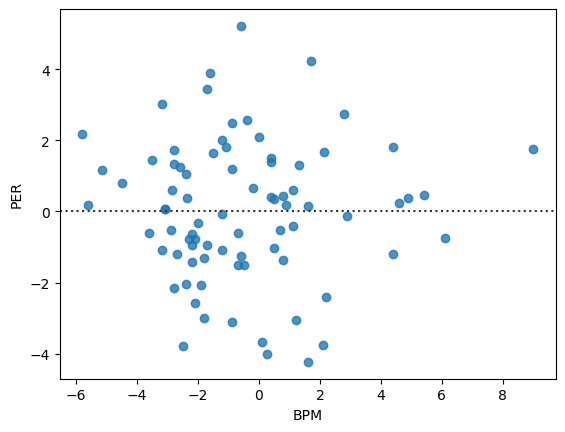

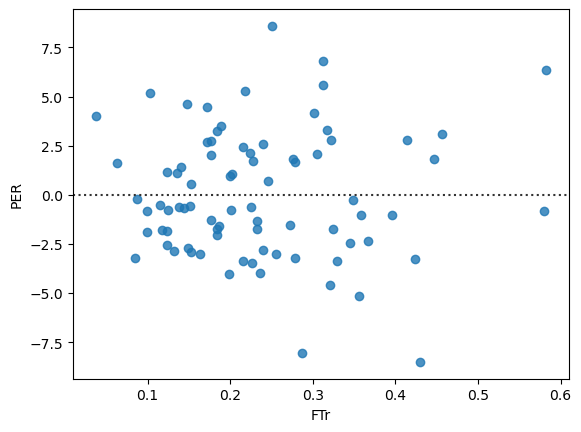

In [8]:
#same thing as previous cell, but for forwards this time (Power forwards + small forwards)

forwards_data_final = data_final_merged[data_final_merged['POSITION'] == 'F']
#print(forwards_data_final.head())
#print(forwards_data_final.shape)


forwards_data_final.dropna(axis = 0, how = 'any')
forwards_var_columns = forwards_data_final[['BPM', 'VORP', 'TS%', 'AVG SPEED OFF',
                                   'AVG SPEED DEF', 'FTr', '3PAr', 'AGE',
                                   'Height_in_feet', 'Weight_actual']]

forward_standardized = pd.DataFrame(StandardScaler().fit_transform(forwards_var_columns), 
                                    columns = forwards_var_columns.columns)
selector = SelectKBest(score_func=f_regression, k = 6)
selector.fit(X = forward_standardized, y = forwards_data_final['PER'])
x = list(selector.get_feature_names_out())

#train test split
q_data = forward_standardized
q_target = forwards_data_final['PER']
q_train_data, q_test_data, q_train_target, q_test_target = train_test_split(
    q_data, q_target, test_size=0.20, random_state=100)


#get combinatorics to test
test_col_list = x
combinations = []
for i in range(1, len(test_col_list)+1):
    combinatorics = [list(x) for x in itertools.combinations(test_col_list, i)]
    combinations.extend(combinatorics)
    
    
adj_r2_list = [] 
train_target_data = q_train_target.values
for column_combo in combinations:
    linear_model = LinearRegression()
    train_input_data = q_train_data[column_combo].values
    linear_model.fit(X = train_input_data, y = train_target_data)
    predicted_test = linear_model.predict(q_test_data[column_combo].values)
    r2 = r2_score(q_test_target.values, predicted_test)
    adj_r2 = 1 - (1 - r2)*((len(train_input_data)-1)/(len(train_input_data) - train_input_data.shape[1]  - 1))
    adj_r2_list.append(adj_r2)

print(max(adj_r2_list))
max_index = adj_r2_list.index(max(adj_r2_list))
print(combinations[max_index])

                    
plt.figure()     
sns.residplot(x = "BPM", 
              y = "PER", 
              data = forwards_data_final) 
plt.figure()
sns.residplot(x = "FTr", 
              y = "PER", 
              data = forwards_data_final) 
#add residual plots for the other ones to show linear regression is appropriate
#caveat is that some of our variables are not independent from each other: technically more accurate way would be
#to consider additive and multipicative effects


(19, 14)
0.9399870278824649
['BPM', 'Height_in_feet']


<Axes: xlabel='Height_in_feet', ylabel='PER'>

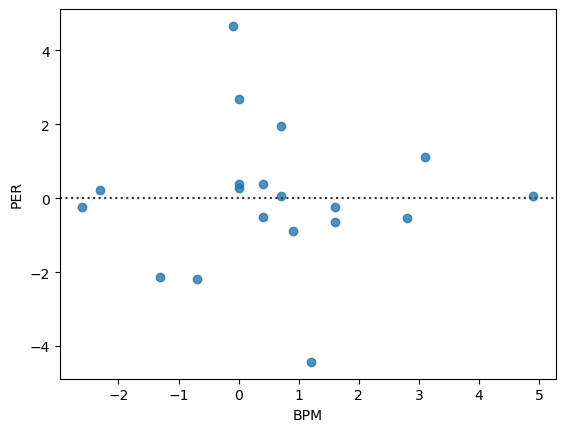

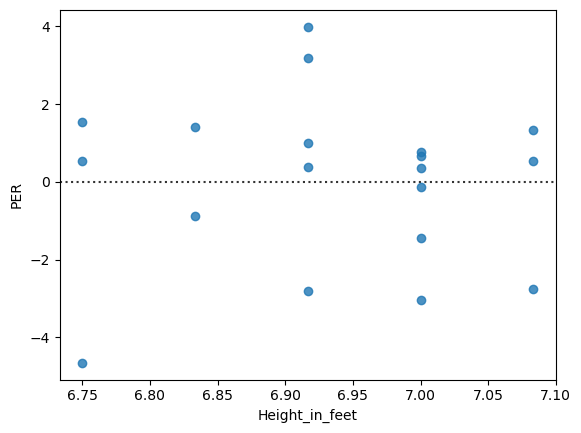

In [9]:
#same thing as previous cell, but for Centers this time

centers_data_final = data_final_merged[data_final_merged['POSITION'] == 'C']
#print(centers_data_final.head())
print(centers_data_final.shape)

centers_data_final.dropna(axis = 0, how = 'any')
centers_var_columns = centers_data_final[['BPM', 'VORP', 'TS%', 'AVG SPEED OFF',
                                   'AVG SPEED DEF', 'FTr', '3PAr', 'AGE',
                                   'Height_in_feet', 'Weight_actual']]

centers_standardized = pd.DataFrame(StandardScaler().fit_transform(centers_var_columns), 
                                    columns = centers_var_columns.columns)

selector = SelectKBest(score_func=f_regression, k = 6)
selector.fit(X = centers_standardized, y = centers_data_final['PER'])

x = list(selector.get_feature_names_out())


#train test split
q_data = centers_standardized
q_target = centers_data_final['PER']
q_train_data, q_test_data, q_train_target, q_test_target = train_test_split(
    q_data, q_target, test_size=0.20, random_state=100)


#get combinatorics to test
test_col_list = x
combinations = []
for i in range(1, len(test_col_list)+1):
    combinatorics = [list(x) for x in itertools.combinations(test_col_list, i)]
    combinations.extend(combinatorics)
    
    
adj_r2_list = [] 
train_target_data = q_train_target.values
for column_combo in combinations:
    linear_model = LinearRegression()
    train_input_data = q_train_data[column_combo].values
    linear_model.fit(X = train_input_data, y = train_target_data)
    predicted_test = linear_model.predict(q_test_data[column_combo].values)
    r2 = r2_score(q_test_target.values, predicted_test)
    adj_r2 = 1 - (1 - r2)*((len(train_input_data)-1)/(len(train_input_data) - train_input_data.shape[1]  - 1))
    adj_r2_list.append(adj_r2)

print(max(adj_r2_list))
max_index = adj_r2_list.index(max(adj_r2_list))
print(combinations[max_index])

plt.figure()     
sns.residplot(x = "BPM", 
              y = "PER", 
              data = centers_data_final) 
plt.figure()
sns.residplot(x = "Height_in_feet", 
              y = "PER", 
              data = centers_data_final) 


#add residual plots for the other ones to show linear regression is appropriate
#caveat is that some of our variables are not independent from each other: technically more accurate way would be
#to consider additive and multipicative effects